In [1]:
import torch
import yaml
import time
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torch_ema import ExponentialMovingAverage

from models.state_mlp import StateMLP
from data.lasa_data import StatePyLASADataset, wrap
from utils.plotting import *
from utils.manifold_utils import *

from flow_matching.utils.manifolds import Manifold, Sphere, Euclidean
from flow_matching.path import GeodesicProbPath
from flow_matching.path.scheduler import CondOTScheduler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from soft_dtw import *
import os
from tqdm import tqdm
from typing import Dict, Any

Using LASA DataSet from /home/stanislav/anaconda3/envs/ml_env/lib/python3.12/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


In [2]:
torch.manual_seed(3420934659826)

In [10]:
run_parameters =  yaml.safe_load(Path("./configs/general.yaml").read_text())
run_parameters

{'train': {'lr': 0.0001,
  'epochs': 100001,
  'batch_size': 100,
  'inf_every': 4000,
  'print_every': 4000,
  'device': 'cpu',
  'inf_runs_num': 3,
  'inf_run_step': 0.05},
 'model': {'hidden_dim': 96, 'num_layers': 6, 'embed_dim': 24},
 'data': {'dim': 3,
  'manifold': 'Sphere',
  'datasets': ['Sshape'],
  'horizon_size': 20,
  'inference_horizon': 10,
  'scale_factor': 2.0,
  'downsample': 5,
  'sample_points': 300,
  'mean': 0.0,
  'std': 0.5},
 'ema': {'warmup': 2000, 'update': 5, 'decay': 0.999},
 'scheduler': {'step': 10000, 'gamma': 0.5}}

In [11]:
manifold_types = {'None' : None, 'Euclidean': Euclidean(), 'Sphere':Sphere()}
train_sets= list(range(6)) #+ list(range(7, 13)) + list(range(14, 20)) + list(range(21, 27))
val_sets = [6]#, 13, 20, 27]
print(train_sets, val_sets)

[0, 1, 2, 3, 4, 5] [6]


In [12]:
manifold = manifold_types[run_parameters['data']['manifold']]
LASA_datasets = run_parameters['data']['datasets']

dataset = StatePyLASADataset(LASA_datasets,
                               train=train_sets,
                               horizon_size=run_parameters['data']['horizon_size'],
                               scaling_factor=run_parameters['data']['scale_factor'],
                               downsample = run_parameters['data']['downsample'],
                               manifold=manifold,
                               dim_to=run_parameters['data']['dim'])

print(dataset.__len__())

train_dataset = torch.utils.data.Subset(dataset, train_sets)

test_dataset = torch.utils.data.Subset(dataset, val_sets)

train_dataloader = DataLoader(train_dataset,
                       batch_size=run_parameters['train']['batch_size'],
                       shuffle=True)

val_dataloader = DataLoader(test_dataset,
                    batch_size=run_parameters['train']['batch_size'],
                    shuffle=True)

test_dataloader = DataLoader(test_dataset,
                    batch_size=1,
                    shuffle=False)

inf_obs, _, label = next(iter(test_dataloader))
inf_obs = inf_obs[:, :2]

gt_test = DataLoader(test_dataset,
                    batch_size=4,
                    shuffle=False)

print(test_dataset.__len__())
print(train_dataset.__len__())

gt_obs, gt_horizon, label = next(iter(gt_test))
print(gt_obs.shape)

7
1
6
torch.Size([1, 200, 7])


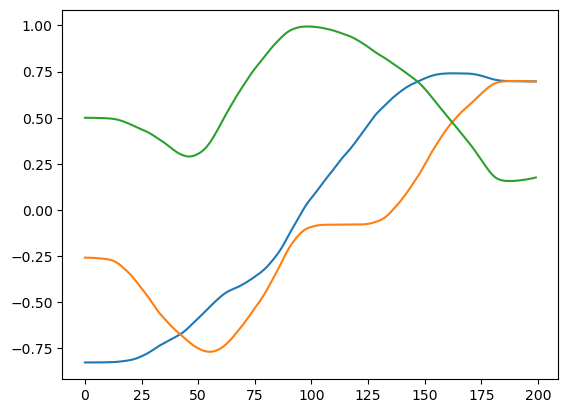

In [ ]:
plt.plot(gt_obs[0,:,:3])

In [13]:
def save_config_to_yaml(config: Dict[str, Any], filepath: str) -> None:
    try:
        with open(filepath, 'w') as f:
            yaml.dump(config, f, default_flow_style=False)  
    except Exception as e:
        raise IOError(f"Failed to save config to {filepath}") from e
    
def get_parameters_from_run(run_name):
    return yaml.safe_load(Path(os.path.join('./runs', run_name, 'config.yaml')).read_text())

def get_model(run_name, action_dim=None):
    parameters = get_parameters_from_run(run_name)
    act_dim = action_dim if action_dim is not None else parameters['data']['dim']
    vf = StateMLP(
        action_dim=act_dim,
        hidden_dim=parameters['model']['hidden_dim'],
        horizon_size=parameters['data']['horizon_size'],
        num_layers=parameters['model']['num_layers'],
        label_embedding_dim=parameters['model']['embed_dim'],
        num_classes=len(parameters['data']['datasets'])
    )
    vf.load_state_dict(torch.load(os.path.join("./runs", run_name, "best_model.pth"), weights_only=True))
    return vf

In [14]:
vf = StateMLP(
    action_dim=run_parameters['data']['dim'],
    hidden_dim=run_parameters['model']['hidden_dim'],
    horizon_size=run_parameters['data']['horizon_size'],
    num_layers=run_parameters['model']['num_layers'],
    label_embedding_dim=run_parameters['model']['embed_dim'],
    num_classes=len(LASA_datasets)
)

ema_vf = ExponentialMovingAverage(
    vf.parameters(),
    decay = run_parameters['ema']['decay'],
)

model_parameters = filter(lambda p: p.requires_grad, vf.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable params number:", params)

Learnable params number: 84304


In [15]:
# run_name = "sine_shape_S2"
# vf.load_state_dict(torch.load(os.path.join("./runs", run_name, "best_model.pth"), weights_only=True))
# ema_vf = ExponentialMovingAverage(
#     vf.parameters(),
#     decay = run_parameters['ema_decay'],
# )
# run_parameters['lr'] = 1e-5
# run_parameters['epochs'] = 30001

In [16]:
import torch
import matplotlib.pyplot as plt
import time

def run_train(vf, 
              train_dataloader, 
              val_dataloader, 
              run_parameters, 
              manifold, 
              ema_vf, 
              dataset, 
              gt_obs, 
              run_name, run_path="./runs"):
    save_path = os.path.join(run_path, run_name)
    os.makedirs(save_path, exist_ok=False)
    save_config_to_yaml(run_parameters, os.path.join(save_path, 'config.yaml'))
    
    device = run_parameters['train']['device']
    vf.to(device)

    optim = torch.optim.Adam(vf.parameters(), lr=run_parameters['train']['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                               step_size=run_parameters['scheduler']['step'], 
                                               gamma=run_parameters['scheduler']['gamma'])

    path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=manifold)

    train_losses = []
    val_losses = []
    lrs = []
    best_val_loss = float('inf')

    start_time = time.time()
    for i in range(run_parameters['train']['epochs']):
        for batch in train_dataloader:
            optim.zero_grad()

            train_loss = step(vf=vf, 
                              batch=batch, 
                              run_parameters=run_parameters, 
                              manifold=manifold, 
                              path=path, 
                              device=device)
            
            train_loss.backward()
            optim.step()

            if i > run_parameters['ema']['warmup'] and i % run_parameters['ema']['update'] == 0: 
                ema_vf.update()

            if i % run_parameters['train']['print_every'] == 0:
                elapsed = time.time() - start_time
                print('| iter {:6d} | {:5.2f} sec | train loss {:8.3f} '
                      .format(i, elapsed, train_loss.item()))
                
                plt.figure()
                plt.plot(train_losses, label='Training Loss')
                plt.plot(val_losses, label='Validation Loss')
                plt.xlabel('Iterations (x print_every)')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(os.path.join(save_path,'loss_plot.png'))
                plt.close()

                plt.figure()
                plt.plot(lrs, label='Learning rate')
                plt.xlabel('Iterations (x print_every)')
                plt.ylabel('lr')
                plt.legend()
                plt.savefig(os.path.join(save_path,'lr_plot.png'))
                plt.close()
                
                with torch.no_grad():
                    ema_vf.store()
                    ema_vf.copy_to()
                    val_batch = next(iter(val_dataloader))
                    loss_val = step(vf=vf, 
                                    batch=val_batch, 
                                    run_parameters=run_parameters, 
                                    manifold=manifold, 
                                    path=path, 
                                    device=device)
                    train_losses.append(train_loss.item())
                    val_losses.append(loss_val.item())
                    if loss_val.item() < best_val_loss:
                        best_val_loss = loss_val.item()
                        torch.save(vf.state_dict(), os.path.join(save_path, 'best_model.pth'))
                    print('| iter {:6d} | validation loss: {:8.3f} '.format(i, loss_val.item()))

                    infered = run_inference(manifold=manifold,
                                model=vf,
                                run_parameters=run_parameters,
                                class_labels=dataset.get_label_maping(),
                                gt_obs=gt_obs)
                    for label_name in infered.keys():
                        plot_flow_on_sphere(infered[label_name]['results'], 
                                            infered[label_name]['samples'], 
                                            gt_obs[dataset.get_label_maping()[label_name]],
                                            label=label_name)
                    ema_vf.restore()
                start_time = time.time()
        lrs.append(scheduler.get_last_lr()[0])
        scheduler.step()
        


    vf.load_state_dict(torch.load(os.path.join(save_path,'best_model.pth'), weights_only=True))
    # with torch.no_grad():
    #     infered = run_inference(manifold=manifold,
    #                             model=vf,
    #                             run_parameters=run_parameters,
    #                             class_labels=dataset.get_label_maping(),
    #                             gt_obs=gt_obs)
    #     for label_name in infered.keys():
    #         plot_flow_on_sphere(infered[label_name]['results'], 
    #                             infered[label_name]['samples'], 
    #                             gt_obs[dataset.get_label_maping()[label_name]],
    #                             label=label_name)
    #         plt.savefig(os.path.join(save_path, f'best_model_flow_{label_name}.png'))
    #         plt.close()

| iter      0 |  0.22 sec | train loss    0.350 
| iter      0 | validation loss:    0.358 


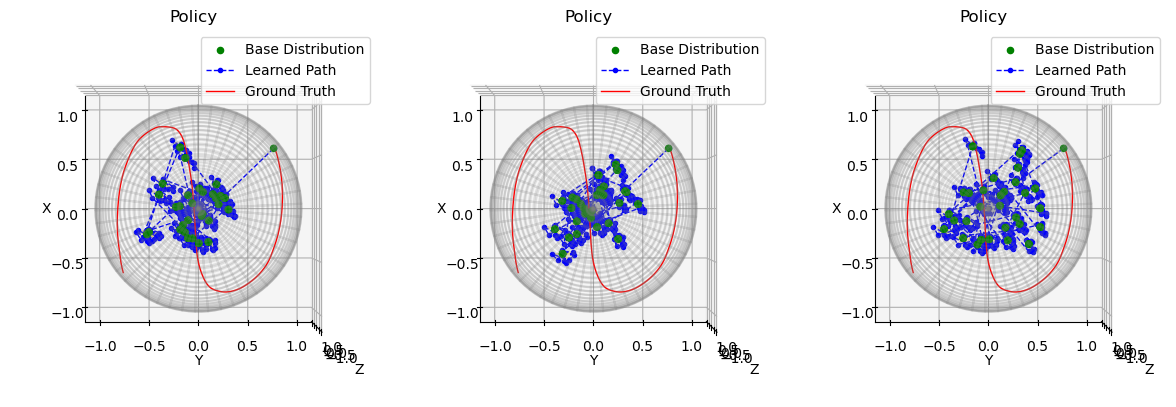

| iter   4000 | 44.69 sec | train loss    0.011 
| iter   4000 | validation loss:    0.008 


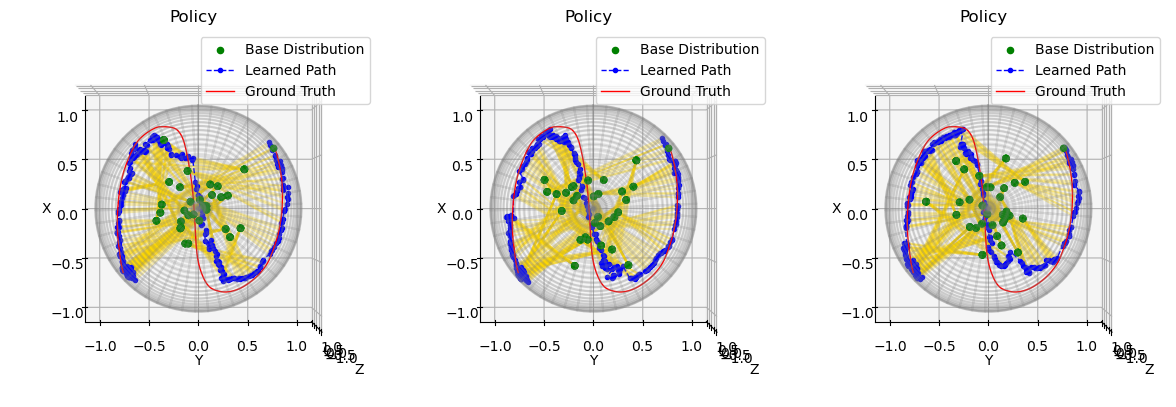

| iter   8000 | 46.75 sec | train loss    0.006 
| iter   8000 | validation loss:    0.006 


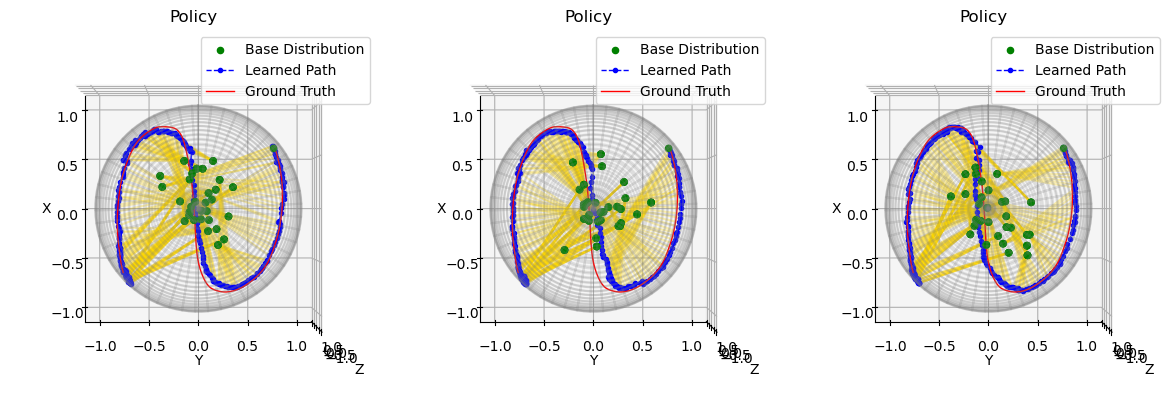

| iter  12000 | 42.71 sec | train loss    0.005 
| iter  12000 | validation loss:    0.006 


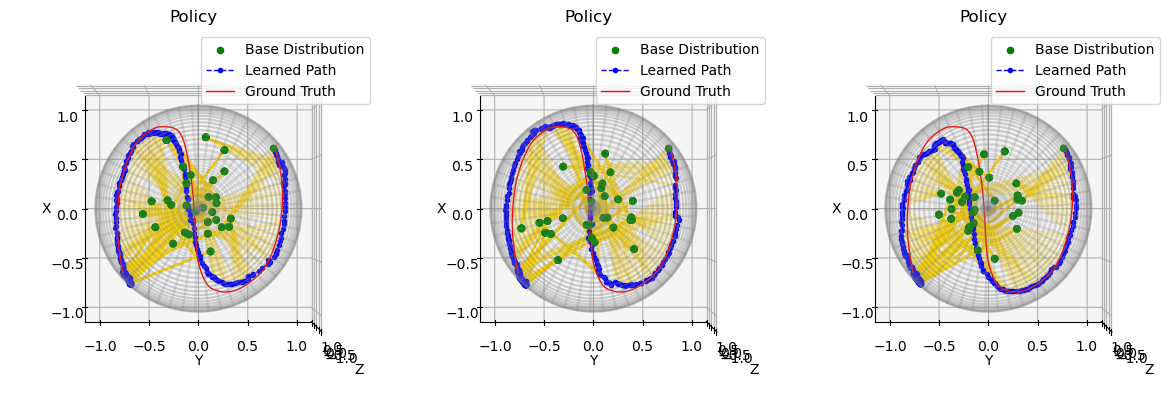

| iter  16000 | 41.32 sec | train loss    0.004 
| iter  16000 | validation loss:    0.004 


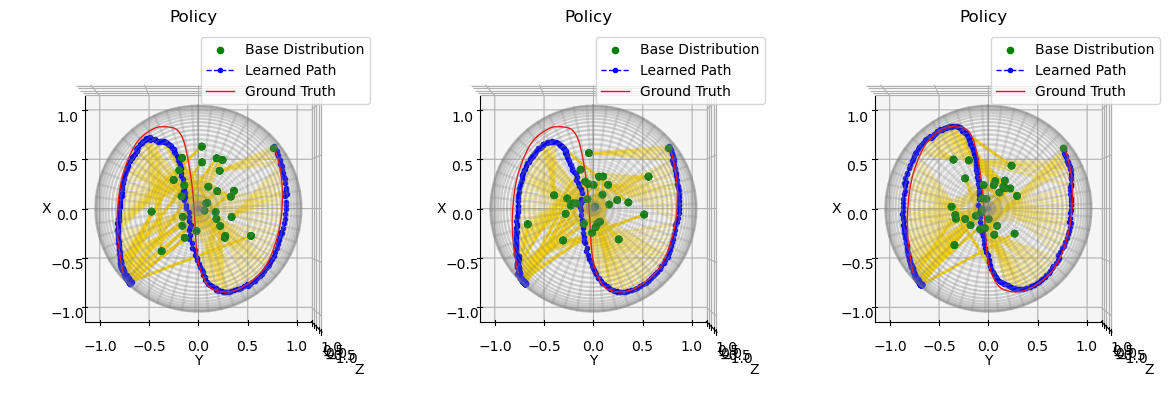

| iter  20000 | 43.04 sec | train loss    0.003 
| iter  20000 | validation loss:    0.002 


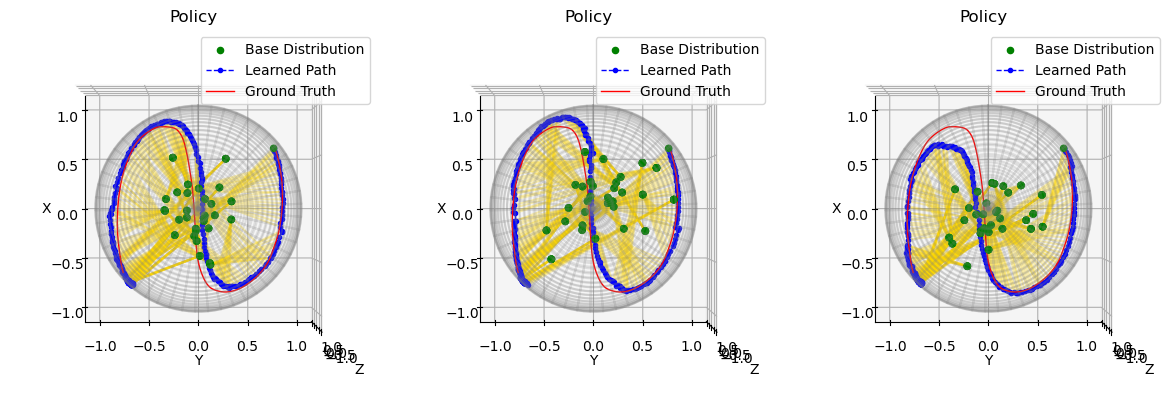

KeyboardInterrupt: 

In [17]:
run_train(vf=vf, 
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            run_parameters=run_parameters, 
            manifold=manifold, 
            ema_vf=ema_vf, dataset=dataset, 
            gt_obs=gt_obs, 
            run_name="s_shape_S2")

In [18]:
infered = run_inference(manifold=manifold,
                                model=vf,
                                run_parameters=run_parameters,
                                class_labels=dataset.get_label_maping(),
                                gt_obs=gt_obs)

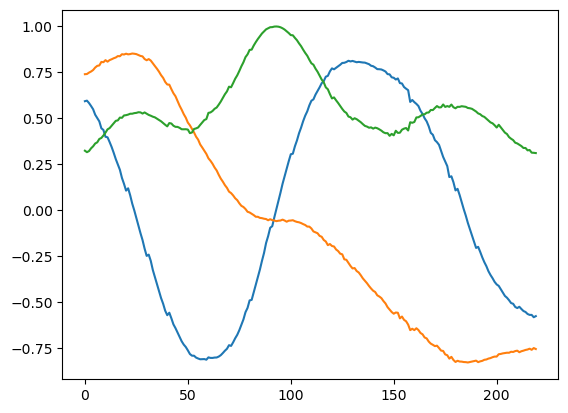

In [20]:
plt.plot(infered['Sshape']['results'][0][:220])

In [21]:
vf_inference = get_model('s_shape_S2')

In [11]:
# infered = run_inference(manifold=Sphere(),
#                                 model=vf_inference,
#                                 run_parameters=run_parameters,
#                                 class_labels=dataset.get_label_maping(),
#                                 gt_obs=gt_obs)
# for label_name in infered.keys():
#     plot_flow_on_sphere(infered[label_name]['results'], 
#                         infered[label_name]['samples'], 
#                         gt_obs[dataset.get_label_maping()[label_name]],
#                         label=label_name,
#                         line_type='--')

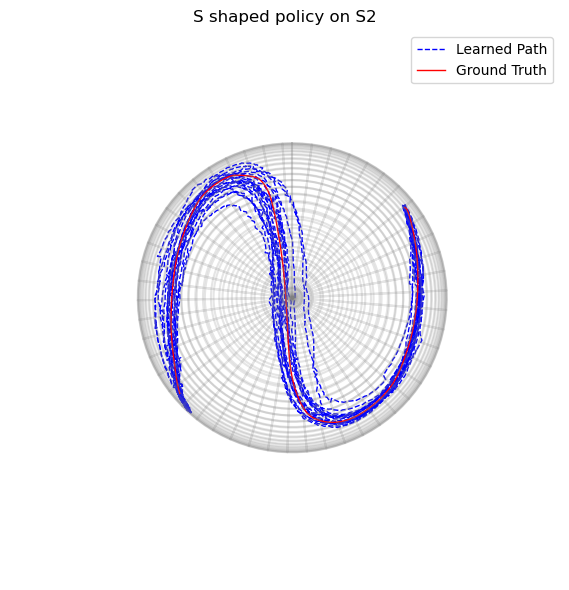

In [26]:
class_labels = dataset.get_label_maping()
dtw = []
for label_name in list(class_labels.keys()):
    results = []
    samples = []
    errors = []
    for _ in range(20): 
        label = torch.tensor(class_labels[label_name],dtype=torch.long).unsqueeze(0)
        res, samp, paths = infer_model(model=vf_inference, 
                        start=gt_obs[class_labels[label_name],0,:run_parameters['data']['dim']], 
                        manifold=manifold,
                        label=label,
                        dim_manifold=run_parameters['data']['dim'],
                        model_horizon= run_parameters['data']['horizon_size'],
                        inference_horizon= 20,#run_parameters['data']['inference_horizon'],
                        sample_points=run_parameters['data']['sample_points'],
                        mean=run_parameters['data']['mean'],
                        std=run_parameters['data']['std'],
                        step_size=0.05,
                        return_intermediates=False)
        results.append(res)
        samples.append(samp)

        # dtw.append(dtw_distance(A=res, B=gt_obs[0,:,:3], dist_func=spherical_distance))
    plot_flow_on_sphere(results, 
                        samples_list=samples, 
                        gt_samples=gt_obs[class_labels[label_name]], 
                        label=label_name, 
                        dynamic=False, one_canvas=True, plot_samples=False, line_type='--', axis_off=True, title="S shaped policy on S2")

In [24]:
dtw = np.array(dtw)

In [25]:
print(dtw.mean(), dtw.std())

23.088375 4.042995


In [ ]:
def calculate_MSE_uncertainty(model, gt_obs, num_samples, run_parameters, base):
    len_gt = gt_obs.size(1)
    errors = []
    gt = gt_obs[0, :, :3]
    class_labels = dataset.get_label_maping()
    for label_name in list(class_labels.keys()):
        label = torch.tensor(class_labels[label_name],dtype=torch.long).unsqueeze(0)
        for i in tqdm(range(num_samples), desc="Evaluating model", leave=False):
            idx = torch.randint(0, len_gt, (1,))
            c, tau_minus_c = sample_context(idx=idx, sample_points=len_gt)
            context = [gt[idx].squeeze(), gt[c].squeeze(), tau_minus_c[0]]
            if base == "S":
                context = torch.cat(context).unsqueeze(0)
                wrapped_vf = WrappedVF(model=ProjectToTangent(vecfield=model, 
                                                            manifold=Sphere()),
                                        obs=context,
                                        label=label)
                wrapped_vf.eval()

                a0 = sample_normal_source(dim=run_parameters['data']['dim']-1,
                                        horizon=run_parameters['data']['horizon_size'], 
                                        manifold=Sphere(), 
                                        mean=run_parameters['data']['mean'],
                                        std=run_parameters['data']['std'],
                                        dim_to=run_parameters['data']['dim'])
                
                solver = RiemannianODESolver(velocity_model=wrapped_vf, 
                                            manifold=Sphere())
            elif base=="Tangent":
                context[0] = Sphere().logmap(gt_obs[0, 0, :3], context[0])
                context[1] = Sphere().logmap(gt_obs[0, 0, :3], context[1])
                context = torch.cat(context).unsqueeze(0)
                wrapped_vf = WrappedVF(model=ProjectToTangent(vecfield=model, 
                                                            manifold=Euclidean()),
                                        obs=context,
                                        label=label)
                wrapped_vf.eval()

                a0 = sample_normal_source(dim=run_parameters['data']['dim'],
                                        horizon=run_parameters['data']['horizon_size'], 
                                        manifold=None, 
                                        mean=run_parameters['data']['mean'],
                                        std=run_parameters['data']['std'],
                                        dim_to=run_parameters['data']['dim'])
                a0 = manifold.proju(gt_obs[0, 0, :3], a0)
                
                solver = RiemannianODESolver(velocity_model=wrapped_vf, 
                                            manifold=Euclidean())
                
            T = torch.tensor([0.0,1.0])
            path_sample = solver.sample(
                            x_init=a0,
                            step_size=0.05,
                            method="midpoint",
                            return_intermediates=False,
                            verbose=False,
                            time_grid = T,
                        )
            infered_data = path_sample.squeeze().clone()
            val = gt[idx+1:idx+1+run_parameters['data']['horizon_size']]
            infered_data = infered_data[:val.size(0)]
            if base=="Tangent":
                infered_data = Sphere().projx(Sphere().expmap(gt_obs[0, 0, :3], infered_data))
            errors.append(geodesic_mse(infered_data, val))
        return errors



In [35]:
errors = np.array(calculate_MSE_uncertainty(model=vf_inference,
                          gt_obs=gt_obs,
                          num_samples=100,
                          run_parameters=run_parameters,
                          base='S'))

In [36]:
print(errors[~np.isnan(errors)].mean(), errors[~np.isnan(errors)].std())

0.0046185553 0.005471557
